In [1]:
import sys
sys.path.append("../") # to access code from rl.distribution, etc.

from dataclasses import dataclass
import numpy as np
from typing import Mapping, Dict, Tuple
from rl.distribution import Categorical, FiniteDistribution, Distribution
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess 
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
import matplotlib.pyplot as plt
import itertools

np.set_printoptions(formatter={'float': lambda x: "{0:.3f}".format(x)})
plt.rcParams['figure.figsize'] = (25, 10)

# Question 1:
With a deterministic policy, we know that:
$$
    \pi(s) = 
    \begin{cases}
    1, & \text{if} ~ a = \pi_D(s) \\
    0, & \text{otherwise}
    \end{cases}
$$

Therefore, the MDP Bellman equations become:
$$
\begin{aligned}
    V^{\pi_D}(s) & = R^{\pi_D}\left( s, \pi_D(s) \right) + \gamma \cdot \sum_{s' \in \mathcal{N}} P^{\pi_D} \left( s, \pi_D(s), s' \right) \cdot V^{\pi_D}(s') \\
    V^{\pi_D}(s) & = Q^{\pi_D}\left( s, \pi_D(s) \right) \\
    Q^{\pi_D}\left( s, \pi_D(s) \right) & = R^{\pi_D}\left( s, \pi_D(s) \right) + \gamma \cdot \sum_{s' \in \mathcal{N}} P^{\pi_D} \left( s, \pi_D(s), s' \right) \cdot V^{\pi_D}(s') \\
    Q^{\pi_D}\left( s, \pi_D(s) \right) & = R^{\pi_D}\left( s, \pi_D(s) \right) + \gamma \cdot \sum_{s' \in \mathcal{N}} P^{\pi_D} \left( s, \pi_D(s), s' \right) \cdot Q^{\pi_D}\left( s', \pi_D(s') \right)
\end{aligned}
$$

# Question 2:
We see that:
$$
\begin{aligned}
V(s) & = \mathbb{E} \left(\left. \sum_{t = 1}^\infty G_t \, \right| S_t = s\right) \\
\therefore V(s) & = \mathbb{E} \left(\left. \sum_{t = 1}^\infty \left( \frac{1}{2} \right)^{t - 1} R_i \, \right| S_t = s\right) \\
\therefore V(s) & = \sum_{t = 1}^\infty \left( \frac{1}{2} \right)^{t - 1} \mathbb{E} \left(\left.  R_i \, \right| S_t = s\right) \\
\therefore V(s) & = \sum_{t = 1}^\infty \left( \frac{1}{2} \right)^{t - 1} \cdot \left[ (1 - a) \cdot a + (1 + a) \cdot (1 - a) \right] \\
\therefore V(s) & = (1 - a)(1 + 2a) \cdot \sum_{t = 0}^\infty \left( \frac{1}{2} \right)^{i} \\
\therefore V(s) & = 2(1 - a)(1 + 2a)
\end{aligned}
$$

The optimal value function can be found as shown below:
$$
\begin{aligned}
V^{*}(s) & = \max_{a \in [0, 1]} 2(1 - a)(1 + 2a) = 2 \left(1 - \frac{1}{4}\right) \left(1 + 2 \cdot \frac{1}{4} \right) = \frac{9}{4} \\
\pi_D(s) & = \text{arg}\max_{a \in [0, 1]} 2(1 - a)(1 + 2a) = \frac{1}{4}
\end{aligned}
$$
# Question 3:
- The state space is: $\mathcal{S} = \{ 0, 1, \cdots, n \}$ where $n$ represents the lilypad
- The action space is: $\mathcal{A} = \{ 'A', 'B' \}$
- The reward for all states is:
$$
R(s) = 
\begin{cases}
    0, & \text{if} ~ s \neq n \\
    1, & \text{otherwise}
\end{cases}
$$
since we want to find the **probability** of escaping the pond.

In [2]:
@dataclass(frozen = True)
class Position:
	position : int

ActionMapping = Mapping[Position, Mapping[str, Categorical[Tuple[Position, float]]]]

class FrogEscape(FiniteMarkovDecisionProcess[Position, str]):
	def __init__(self, length : int):
		self.length = length # resembles n in the problem
		super().__init__(self.get_action_transition_reward_map())

	def get_action_transition_reward_map(self) -> ActionMapping:
		d : Dict[Position, Dict[str, Categorical[Tuple[Position, float]]]] = {}

		for state in range(1, self.length):
			state = Position(position = state)

			inner_dict : Dict[str, Categorical[Tuple[Position, float]]] = {}

			# if the frog croaks sound A...
			dict_A = {}

			dict_A[(Position(position = state.position - 1), 0.0)] = state.position / self.length
			if state.position + 1 == self.length: # if the frog escapes, reward = 1.0, else 0.0
				dict_A[(Position(position = self.length), 1.0)] = 1 - state.position / self.length

			else:
				dict_A[(Position(position = state.position + 1), 0.0)] = 1 - state.position / self.length

			inner_dict['A'] = Categorical(dict_A)

			# if the frog croaks sound B... if the frog escapes, reward = 1.0, else 0.0
			dict_B = {(Position(position = i), 0.0) : 1. / self.length for i in range(self.length) if i != state.position}
			dict_B[(Position(position = self.length), 1.0)] = 1. / self.length
			inner_dict['B'] = Categorical(dict_B)

			d[state] = inner_dict

		return d

### For different lengths of the river, I create an instance of the Markov decision process `FrogEscape` and then find the optimal value function and policy amongst all the possible $2^{n-1}$ policies possible, and plot the optimal escape probabilities and the optimal policies, as a function of the length of the river:

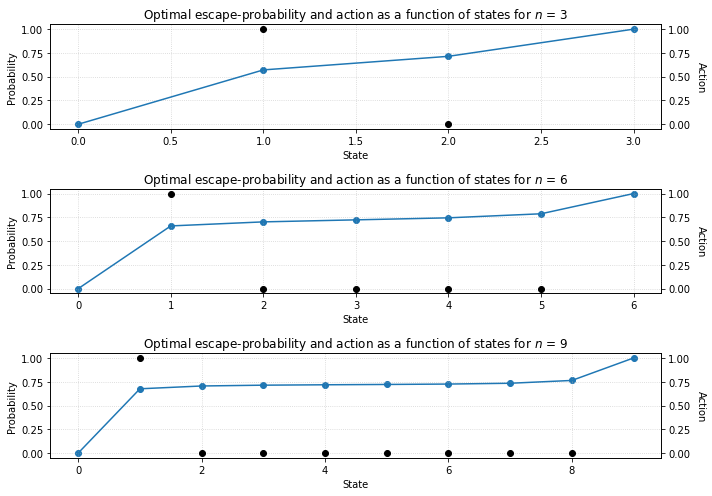

In [3]:
lengths = range(3, 10, 3)
fig, axes = plt.subplots(len(lengths), figsize = (10, 7))
for j, length in enumerate(lengths):
    puzzle : FiniteMarkovDecisionProcess[Position, str] = FrogEscape(length = length)

    # generate all possible combinations of actions for a given position
    outcomes = [[(pos, act) for act in ['A', 'B']] for pos in range(1, length)]
    optimal_policy = None # will store the optimal policy
    optimal_value = None # will store the optimal value function
    max_val = - np.inf # will be used to find the optimal value function

    # then form the cartesian product of all those lists
    for i in itertools.product(*outcomes):
        my_dict : Dict[Position, str] = {Position(position = pos) : act for pos, act in i}
        policy : FiniteDeterministicPolicy[Position, str] = FiniteDeterministicPolicy(my_dict)
        implied_mrp : FiniteMarkovRewardProcess[Position] = puzzle.apply_finite_policy(policy)
        val = implied_mrp.get_value_function_vec(gamma = 1.0)

        # store the optimal policy
        if np.linalg.norm(val, ord = 1) > max_val:
            optimal_policy = my_dict
            optimal_value = val
            max_val = np.linalg.norm(val, ord = 1)

    # plot the optimal escape-probabilities
    optimal_value = [0.] + [i for i in optimal_value] + [1.0]
    axes[j].plot(range(length + 1), optimal_value)
    axes[j].scatter(range(length + 1), optimal_value)

    ax2 = axes[j].twinx()
    policy = [0.0 if act == 'A' else 1.0 for act in optimal_policy.values()]
    ax2.scatter(range(1, length), policy, color = 'black')

    axes[j].set_title(f"Optimal escape-probability and action as a function of states for $n$ = {length}")
    axes[j].set_xlabel("State")
    axes[j].set_ylabel("Probability")
    ax2.set_ylabel("Action", rotation = -90, labelpad=15)
    axes[j].grid(alpha = 0.6, linestyle = ':')

fig.tight_layout()
plt.show()

# Question 4:
Since $s' \sim N \left(s, \sigma^2 \right)$, we know that $e^{as'} \sim \text{lognormal} \left( a\mu, a^2 \sigma^2 \right)$ and therefore, we need to minimize the following:
$$
\min_{a \in \mathbb{R}} \mathbb{E} \left(e^{as'}\right) = \exp{a\mu + \frac{a^2 \sigma^2}{2}}
$$

By letting $f(a) = \exp{a\mu + \frac{a^2 \sigma^2}{2}}$, we see that:
$$
\begin{aligned}
f'(a) & = \exp{a\mu + \frac{a^2 \sigma^2}{2}} \cdot \left( \mu + a \sigma^2 \right) \\
f''(a) & = \exp{a\mu + \frac{a^2 \sigma^2}{2}} \cdot \left[ \left( \mu + a \sigma^2 \right)^2 + \sigma^2 \right] \geq 0 \, \forall \, a \in \mathbb{R} 
\end{aligned}
$$

Therefore, we know that $f(a)$ does have a global minimum, which is achieved at the following optimal policy:
$$
a^{*} = - \frac{\mu}{\sigma^2}
$$

The corresponding optimal value function is:
$$
f\left(a^*\right) = \exp{- \frac{\mu}{2 \sigma^2}}
$$